In [2]:
%load_ext autoreload
%autoreload 2

import torch
from circuits_benchmark.utils.get_cases import get_cases
import iit.model_pairs as mp
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
from circuits_benchmark.benchmark.benchmark_case import BenchmarkCase
import os

task_idx = '4'
out_dir = f'results/tuned_lens/{task_idx}'
os.makedirs(out_dir, exist_ok=True)

task: BenchmarkCase = get_cases(indices=[task_idx])[0]

ll_model_loader = get_ll_model_loader(task, interp_bench=True)
hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
# turn off grads
model.eval()
model.requires_grad_(False)

hl_model = task.get_hl_model()
model_pair = mp.StrictIITModelPair(hl_model, model, hl_ll_corr)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ll_model.pth:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

ll_model_cfg.pkl:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_attn_scores': HookPoint(), 'b

In [18]:
for i in loader:
    print(i[0])
    break

tensor([[2, 5, 5,  ..., 4, 5, 0],
        [2, 6, 5,  ..., 4, 4, 1],
        [2, 5, 0,  ..., 5, 6, 1],
        ...,
        [2, 5, 6,  ..., 5, 5, 6],
        [2, 0, 6,  ..., 1, 5, 0],
        [2, 1, 0,  ..., 6, 1, 6]])


In [12]:
max_len = 1000
unique_test_data = task.get_clean_data(max_samples=max_len, unique_data=True)
# def collate_fn(batch):
    
#     return x[0]

loader = torch.utils.data.DataLoader(unique_test_data, batch_size=256, shuffle=False, drop_last=False)

In [23]:
from interp_utils.lens.tuned_lens import do_tuned_lens
from interp_utils.lens import TunedLensConfig

tuned_lens_results, labels, train_metrics = do_tuned_lens(
    model_pair, loader, 
    TunedLensConfig(
        num_epochs=50,
        lr=1e-2,
    ),
    return_train_metrics=True
)

100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


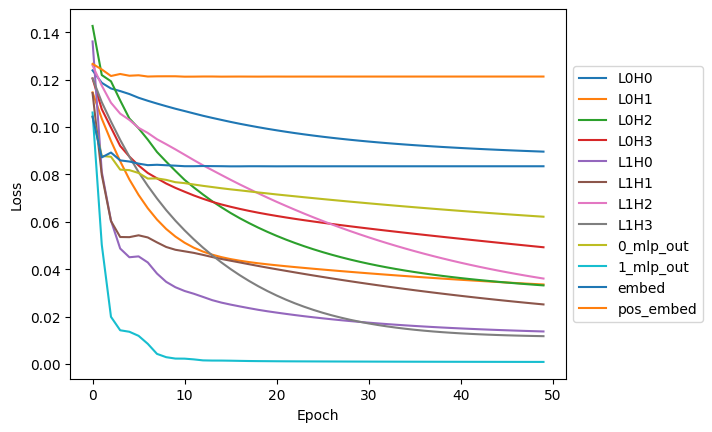

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

metric_df = pd.DataFrame(train_metrics)
metric_df.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(f"{out_dir}/tuned_lens_loss.pdf", bbox_inches='tight')
pass

In [25]:
from iit.utils.node_picker import get_all_individual_nodes_in_circuit

nodes = get_all_individual_nodes_in_circuit(model, model_pair.corr)
def convert_ll_node_to_str(node: mp.LLNode):
    if 'attn' in node.name:
        block = node.name.split('.')[1]
        head = node.index.as_index[2]
        return f"L{block}H{head}"
    if 'mlp' in node.name:
        block = node.name.split('.')[1]
        return f"{block}_mlp_out"

nodes = [convert_ll_node_to_str(node) for node in nodes]
nodes

['0_mlp_out', 'L1H0', 'L1H1', '1_mlp_out']

In [26]:
from scipy import stats
import plotly.graph_objects as go

def plot_pearson(key, tuned_lens_results, labels, model_pair, nodes, show=False):
    in_circuit_str = "in circuit" if k in nodes else "not in circuit"
    fig = go.Figure()

    for i in range(tuned_lens_results[k].shape[1]):
        y = labels[:, i].squeeze().detach().cpu().numpy()
        x = tuned_lens_results[k][:, i].detach().cpu().numpy().squeeze()
        if model_pair.hl_model.is_categorical():
            y = y.argmax(axis=-1)
            x = x.argmax(axis=-1)
            
        pearson_corr = stats.pearsonr(x, y)
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name=f"pos {i}, corr: {pearson_corr[0]:.2f}"))

    fig.update_layout(title=f"Logit Lens Results for {k} ({in_circuit_str})", yaxis_title="True Logits", xaxis_title="Logit Lens Results")
    if show:
        fig.show()
    fig.write_image(f"{out_dir}/tuned_lens_logit_lens_results_for_{k}.png")

for k in tuned_lens_results.keys():
    plot_pearson(k, tuned_lens_results, labels, model_pair, nodes, show=False)

k = "L1H0"
plot_pearson(k, tuned_lens_results, labels, model_pair, nodes, show=True)

In [27]:
import pandas as pd
import plotly.express as px
import numpy as np

def plot_combined_pearson(tuned_lens_results, labels, model_pair, nodes, abs_corr=True):
    pearson_corrs = {}
    for k in tuned_lens_results.keys():
        x = tuned_lens_results[k].detach().cpu().numpy().squeeze()
        y = labels.detach().cpu().numpy().squeeze()
        if model_pair.hl_model.is_categorical():
            y = y.argmax(axis=-1)
            x = x.argmax(axis=-1)
        for i in range(x.shape[1]): 
            pearson_corr = stats.pearsonr(x[:, i], y[:, i])
            k_ = k + "(IC)" if k in nodes else k
            if k_ not in pearson_corrs:
                pearson_corrs[k_] = {}
            if np.isnan(pearson_corr.correlation):
                pearson_corrs[k_][str(i)] = 0
            elif abs_corr:
                pearson_corrs[k_][str(i)] = abs(pearson_corr.correlation) 
            else:
                pearson_corrs[k_][str(i)] = pearson_corr.correlation

    pearson_corrs = pd.DataFrame(pearson_corrs)
    fig = px.imshow(pearson_corrs, 
            # set color map
                color_continuous_scale="Viridis",
                # set axis labels   
                labels=dict(y="Position", x="Layer/Head", color="Pearson Correlation"),
    )
    # remove margins around plot
    fig.update_layout(margin=dict(l=0, r=0, t=1, b=0))

    # make xticks bigger
    fig.update_xaxes(tickfont=dict(size=15))

    fig.show()
    fig.write_image(f"{out_dir}/tuned_lens_combined_pearson.png")

plot_combined_pearson(tuned_lens_results, labels, model_pair, nodes, abs_corr=False)